In [1]:
from fastai.vision.all import *
from pathlib import Path
from fastai.vision.all import vision_learner
from fastai.callback.tracker import EarlyStoppingCallback
from PIL import ImageFile
#vscode fix
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [12]:
#path for datamodel
path = Path('../ImageScraping/allShoesTraining')

In [29]:
#create Test Set with 5% of images, assuming the data is created by the duckScrape.py file
testPercent = 0.05 #percent you want to extract to be used as a test set
test_path = Path('../ImageScraping/allShoesTest')
for class_folder in os.listdir(path):
    class_path = os.path.join(path, class_folder, "all")
    image_files = os.listdir(class_path)
    num_images = len(image_files)
    num_test_images = int(num_images * testPercent)
    random.shuffle(image_files)
    for i in range(num_test_images):
        src_path = os.path.join(class_path, image_files[i])
        dst_path = os.path.join(test_path, class_folder, image_files[i])
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        shutil.move(src_path, dst_path)

FileNotFoundError: [Errno 2] No such file or directory: '../ImageScraping/allShoesTraining/adidas Climacool 02/all'

In [32]:
import os
import shutil

# Define the path to the parent folder
parent_folder = path

# Loop over all subfolders in the parent folder
for foldername in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, foldername)
    
    # Check if the folder contains a subfolder called "all"
    if os.path.isdir(os.path.join(folder_path, "all")):
        
        # Define the path to the "all" folder
        all_folder_path = os.path.join(folder_path, "all")
        
        # Loop over all files in the "all" folder
        for filename in os.listdir(all_folder_path):
            file_path = os.path.join(all_folder_path, filename)
            
            # Check if the file is an image
            if filename.endswith(".jpg") or filename.endswith(".png"):
                
                # Define the new path for the file
                new_file_path = os.path.join(folder_path, filename)
                
                # Move the file from the "all" folder to the parent folder
                shutil.move(file_path, new_file_path)
        
        # Remove the "all" folder
        os.rmdir(all_folder_path)

In [ ]:
#first attempt, used validation set percentage of 30%, and aug_transforms with default parameters
data= ImageDataLoaders.from_folder(path, train='.', valid_pct=0.3,
                                   item_tfms=Resize(224), batch_tfms=aug_transforms(),
                                   bs=64, num_workers=0)

In [33]:
#second attempt, decreased validation set percentage to 20% and using a max rotation of 90 degrees for better performance in vertical images
data= ImageDataLoaders.from_folder(path, train='.', valid_pct=0.2,
                                   item_tfms=Resize(224), batch_tfms=aug_transforms(max_rotate=90.0),
                                   bs=64, num_workers=0)

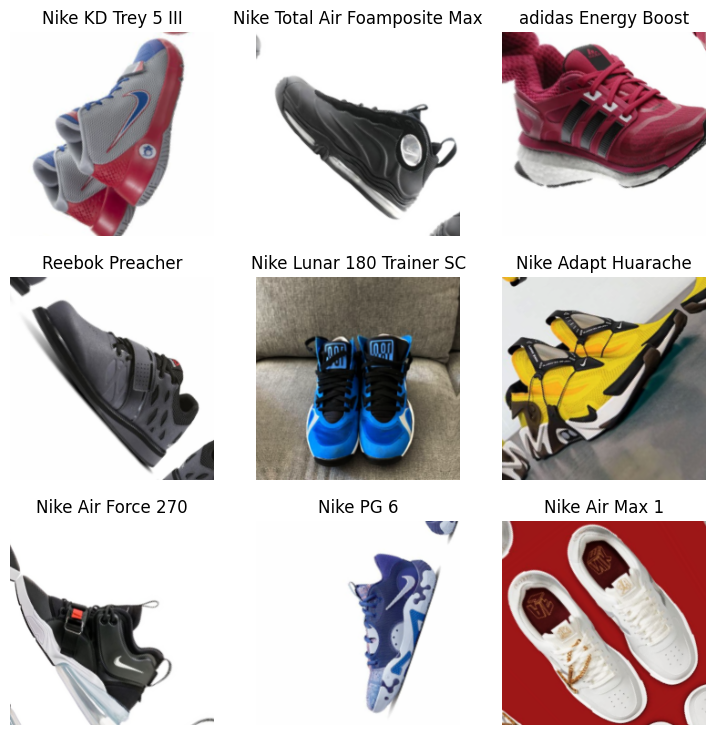

In [34]:
#show quick preview of the data to make sure everything worked
batch = data.show_batch()

In [ ]:
#first attempt, using only accuracy as a metric
learn = vision_learner(data, resnet34, metrics=accuracy)

In [ ]:
#second attempt, adding an earlier stop for faster training and Precision as a metric with macro as a paremeter due to popular shoes having more images than others
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2)
progress_cb = ProgressCallback()
 
learn = vision_learner(data, resnet34, metrics=[accuracy,
               Precision(average='macro'),Recall(average='macro')],
                cbs=[early_stop_cb])

In [35]:
#third attempt, adding Recall as a metric with macro, and decreasing the patience for the early stop
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=1)
progress_cb = ProgressCallback()
 
learn = vision_learner(data, resnet34, metrics=[accuracy,
               Precision(average='macro'),Recall(average='macro')],
                cbs=[early_stop_cb])



/home/daniel/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
#using 10 epochs for learning, haven't experimented with more/less yet. Seems to be a good spot
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,5.920284,4.971115,0.175909,0.203098,0.162401,38:20
1,3.751216,2.830734,0.469097,0.540177,0.466509,37:53
2,3.314045,2.359692,0.546321,0.596910,0.544604,37:43
3,3.026204,2.135157,0.581990,0.624220,0.581906,37:46
4,2.881186,1.976947,0.613098,0.644494,0.612117,38:00
5,2.765233,1.870067,0.634129,0.663427,0.633374,37:54


In [9]:
#exporting the model
learn.export('./allshoesnewmodel2.pkl')

In [14]:
#Uncomment the bottom line in order to load a previously trained model
#learn = load_learner('../ImageScraping/allShoesTraining/allshoesnewmodel2.pkl')

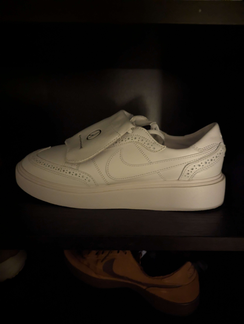

'Puma Ralph Sampson Lo'

'Probability: 0.2453'

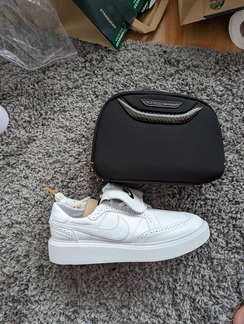

'G-Dragon x Nike Kwondo 1'

'Probability: 0.3268'

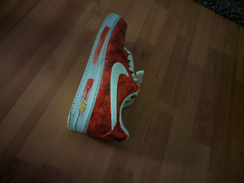

'adidas J Wall 2'

'Probability: 0.2729'

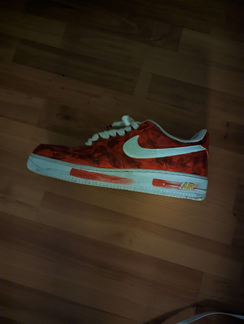

'Nike Air Force 1 Low'

'Probability: 0.3378'

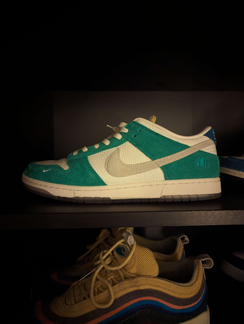

'Nike Dunk Low'

'Probability: 0.2654'

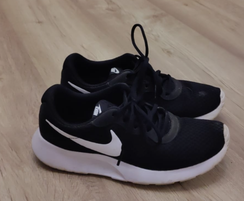

'Nike Free Run 5.0'

'Probability: 0.1301'

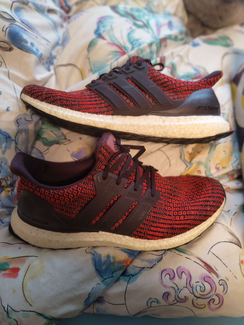

'adidas Ultraboost'

'Probability: 0.7121'

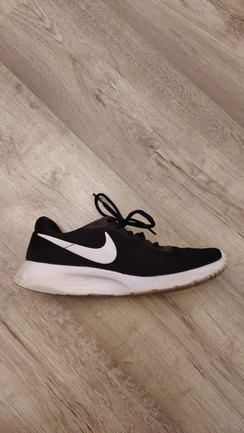

'Jordan Eclipse'

'Probability: 0.0850'

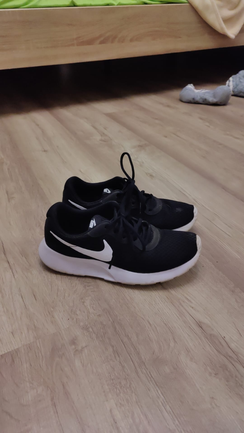

'Nike SB Vulc Rod'

'Probability: 0.1739'

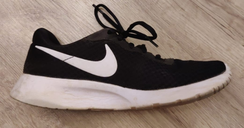

'Nike SB Eric Koston 1'

'Probability: 0.1165'

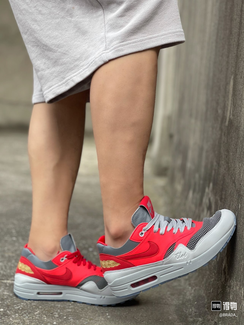

'Nike Air Max 1'

'Probability: 0.1638'

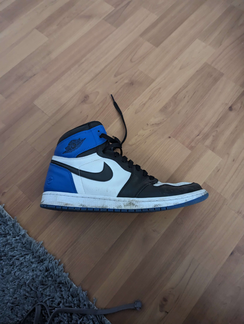

'Air Jordan 1 High'

'Probability: 0.9030'

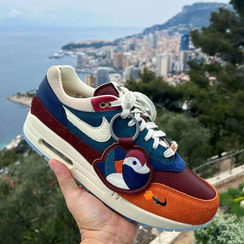

'Nike Air Max 1'

'Probability: 0.2668'

In [15]:
#test your model quickly, using the ml/images folder as a container for images to predict the shoe model on
from PIL import Image

import os

resultList = []


for filename in os.listdir("./images"):
    f = os.path.join("./images", filename)
    
    img = Image.open(f)
    wpercent = (244/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((244,hsize), Image.Resampling.LANCZOS)
    
    pred, pred_idx, probs = learn.predict(f)
    probString = f"Probability: {probs[pred_idx]:.04f}"
    resultList.append((img,pred,probString))
for result in resultList:
    display(result[0])
    display(result[1])
    display(result[2])
    